# User acquisition analytics

In this notebook we are going to embed our user data in order to draw relevant conclusions in terms of our user acquisition.

Quite recently we have run 2 campaings - an older one at the end of August, 2023, and a more recent one right before the Christmas period of 2023. The first campaign operated with more generic messages, while the latter one was aided by XYZCr$$d, a made up influencer.

In terms of user data, we have 
1. the ad creative the users clicked on
2. the signup date as a unix timestamp
3. and the average daily activity (measured in API calls / day)

Embedding those inputs in a vectorspace enables us to cluster them to find meaningful user groups.

To understand the embeddings we will
- create a UMAP visualisation
- and examine the cluster labels' association with initial features

## Boilerplate

### Installation

<div class="alert alert-block alert-warning">
Replace <code>YOUR_GITHUB_TOKEN</code> in the install script. To get your token follow the instructions in the <a href="../README.md">README.md</a>
</div>

In [1]:
%pip install  'https://us-central1-data-359211.cloudfunctions.net/github-proxy/superlinked-2.24.0-py3-none-any.whl?token=YOUR_GITHUB_TOKEN'
%pip install scikit-learn==1.4.0 umap-learn==0.5.5
%pip install update jupyter ipywidgets

### Imports and constants

In [2]:
from datetime import datetime, timedelta
import os

import altair as alt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import umap

from superlinked.evaluation.charts.recency_plotter import RecencyPlotter
from superlinked.evaluation.vector_sampler import VectorSampler
from superlinked.framework.common.dag.context import CONTEXT_COMMON, CONTEXT_COMMON_NOW
from superlinked.framework.common.dag.period_time import PeriodTime
from superlinked.framework.common.embedding.number_embedding import Mode
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.event_schema import event_schema
from superlinked.framework.common.schema.schema_object import String, Integer, Timestamp
from superlinked.framework.common.schema.schema_reference import SchemaReference
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import InMemoryExecutor, InMemoryApp
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.index.effect import Effect
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.query.result import Result
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.number_space import NumberSpace, Mode
from superlinked.framework.dsl.space.recency_space import RecencySpace

alt.renderers.enable("mimetype")
alt.data_transformers.disable_max_rows()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
USER_DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-user-acquisiton-analytics/user_acquisiton_data.csv"
NOW_TS = 1708529056
EXECUTOR_DATA = {CONTEXT_COMMON: {CONTEXT_COMMON_NOW: NOW_TS}}

## Read and explore dataset

In [4]:
user_df: pd.DataFrame = pd.read_csv(USER_DATASET_URL)
print(f"User data dimensions: {user_df.shape}")
user_df.head()

User data dimensions: (8000, 4)


id  signup_date  \
0   0   1693044869   
1   1   1694581577   
2   2   1693557423   
3   3   1693313203   
4   4   1692863645   

                                                                                                                                                     ad_creative  \
0  Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!   
1                                                                       Join a thriving gaming community and challenge your skills against formidable opponents!   
2                                        Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!   
3                                        Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!   
4  Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!   

   activity  
0      0.30  
1      1.14  
2      0.01  
3      0.30  
4      0.12

In [5]:
# The influencer backed message seem to work a lot better.
pd.DataFrame(user_df["ad_creative"].value_counts())

ad_creative
Unleash your gaming potential! Upgrade to premium for 2 months free and dominate the competition with XYZCr$$d!                                                       1785
Ready to level up? Join XYZCr$$d now for intense gaming battles and exclusive rewards!                                                                                1312
Embark on your gaming journey with XYZCr$$d! Join now and experience the thrill of competing against the finest players worldwide!                                     715
Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!          671
Step into the arena of endless possibilities! Join now to engage in exhilarating gaming competitions and forge friendships with fellow gamers along the way!           541
Calling all gamers! Don't miss out on your chance to excel. Join XYZCr$$d today for unparalleled gaming excitement and endless challenges!                             533
Join a thriving gaming community and challenge your skills against formidable opponents!                                                                               501
Elevate your gaming experience! Upgrade now for 2 months free premium access and immerse yourself in the ultimate gaming community of XYZCr$$d!                        501
Seeking thrilling gaming adventures? Join our community of gamers and embark on epic quests against worthy adversaries!                                                452
Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!                                                347
Enter the realm of gaming excellence! Join our vibrant community and compete against some of the most skilled players worldwide!                                       343
Become a gaming legend! Join XYZCr$$d now and test your skills against top-tier players from around the globe. Upgrade to premium for 2 months free!                   299

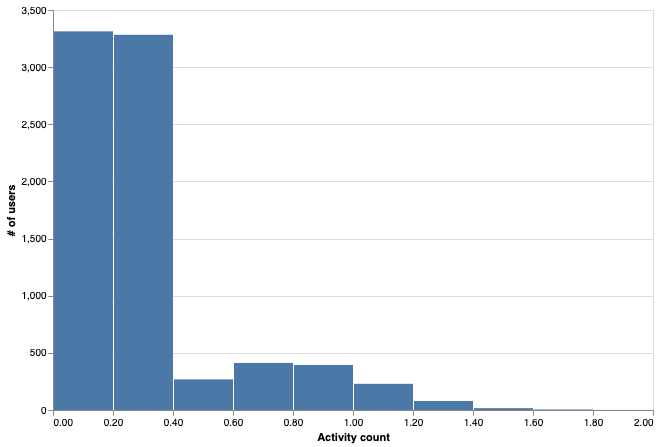

In [6]:
# The distribution of activity shows a 2-mode distribution - possibly in connection with the two campaings for user acquisition as newer users 
# did not have time to accumulate activity like older users. Also this informs NumberSpace parameters
alt.Chart(user_df).mark_bar().encode(
    alt.X("activity:Q", bin=True, title="Activity count"),
    alt.Y('count()', title="# of users"),
).properties(width=600, height=400)

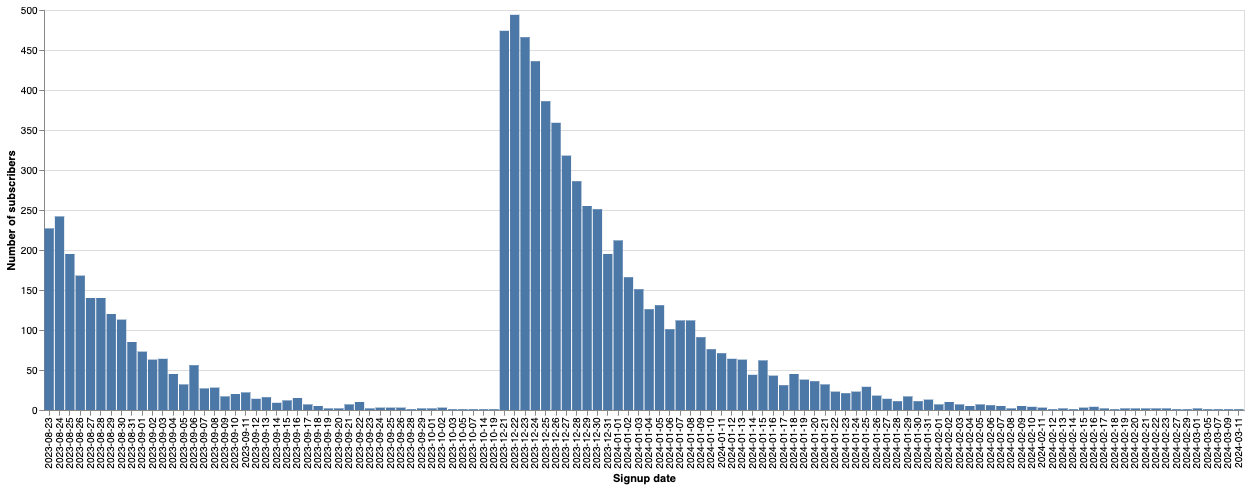

In [7]:
# new users per signup date - further confirms the second campaign working great
# note the jump from 2023-10-19 to 2023-12-21 at the spike - we only deal with campaign data
# also this suggests we need 2 period times to handle the two campaings properly - 65 and 185 days seem fine.
dates: pd.DataFrame = pd.DataFrame(
    {"date": [str(datetime.fromtimestamp(ts).date()) for ts in user_df["signup_date"]]})
dates_to_plot = pd.DataFrame(dates.value_counts(), columns=["count"]).reset_index()
alt.Chart(dates_to_plot).mark_bar().encode(
    alt.X("date", title="Signup date"),
    alt.Y("count", title="Number of subscribers")
).properties(height=400, width=1200)
# we have 8k users, roughly 2k subscribed with the first push, 6k with the second. Maybe the second push brought in subscribers intrinsically, 
# but also through spillover to old ads as well - will see that by the ad creatives

## Set up Superlinked

In [8]:
@schema
class UserSchema:
    ad_creative: String
    activity: Integer
    signup_date: Timestamp
    id: IdField

In [9]:
user = UserSchema()

In [10]:
# embed the creatives in a semantic space to inform the model about which creative hooked the user
# the representation is also useful as it gives the opportunity to group similar meaning ad creatives
creative_space = TextSimilaritySpace(text=user.ad_creative, model="sentence-transformers/all-mpnet-base-v2")
# encode activity for the relevant range with similar mode (btw any other mode could work just for this here)
activity_space = NumberSpace(number=user.activity, mode=Mode.SIMILAR, min_value=0, max_value=1.25)
# encode signup date so the clustering can take this into account
recency_space = RecencySpace(timestamp=user.signup_date, 
                             period_time_list=[
                                 PeriodTime(timedelta(days=65)), 
                                 PeriodTime(timedelta(days=185))],
                             negative_filter=0.0
                            )

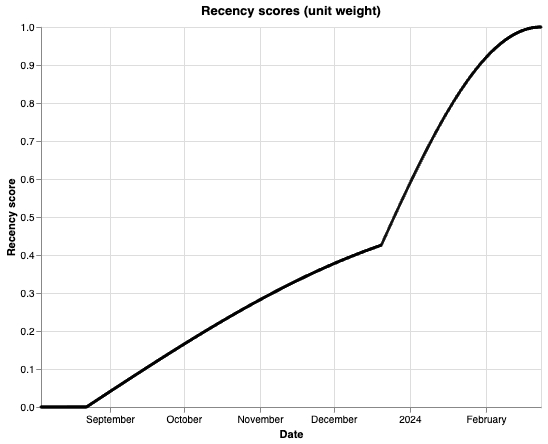

In [11]:
# this plot helps us understanding our recency scores
recency_plotter = RecencyPlotter(recency_space)
recency_plotter.plot_recency_curve()

In [12]:
user_index = Index(spaces=[creative_space, activity_space, recency_space])

In [13]:
user_df_parser = DataFrameParser(schema=user)

In [14]:
source_user: InMemorySource = InMemorySource(user, parser=user_df_parser)
executor: InMemoryExecutor = InMemoryExecutor(sources=[source_user], indices=[user_index])
app: InMemoryApp = executor.run()

In [15]:
source_user.put([user_df])

Taking long? You are welcome to take a look at [VectorHub](https://hub.superlinked.com/), Superlinked's educational space about our shared passion: vectors.

## Load features

In [16]:
# collect all vectors from the app
vs = VectorSampler(app=app)
vector_collection = vs.get_all_vectors(user_index, user)
vectors = vector_collection.vectors

In [17]:
vectors.shape

(8000, 776)

## Clustering

In [18]:
# fit a clustering model
# this is done after some basic parameter search - not the point of this notebook
dbscan = DBSCAN(eps=0.45, min_samples=200)
dbscan.fit(vectors)

DBSCAN(eps=0.45, min_samples=200)

In [19]:
# save labels
user_df["cluster_label"] = dbscan.labels_
user_df.head()

id  signup_date  \
0   0   1693044869   
1   1   1694581577   
2   2   1693557423   
3   3   1693313203   
4   4   1692863645   

                                                                                                                                                     ad_creative  \
0  Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!   
1                                                                       Join a thriving gaming community and challenge your skills against formidable opponents!   
2                                        Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!   
3                                        Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!   
4  Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!   

   activity  cluster_label  
0      0.30              0  
1      1.14              0  
2      0.01              0  
3      0.30              0  
4      0.12              0

### Visualize

In [20]:
# fit UMAP and transform dataset
umap_transform = umap.UMAP(random_state=0, transform_seed=0, n_jobs=1)
umap_transform = umap_transform.fit(vectors)
umap_vectors = umap_transform.transform(vectors)
umap_df = pd.DataFrame(umap_vectors, columns=["dimension_1", "dimension_2"])
umap_df["cluster_label"] = user_df["cluster_label"]

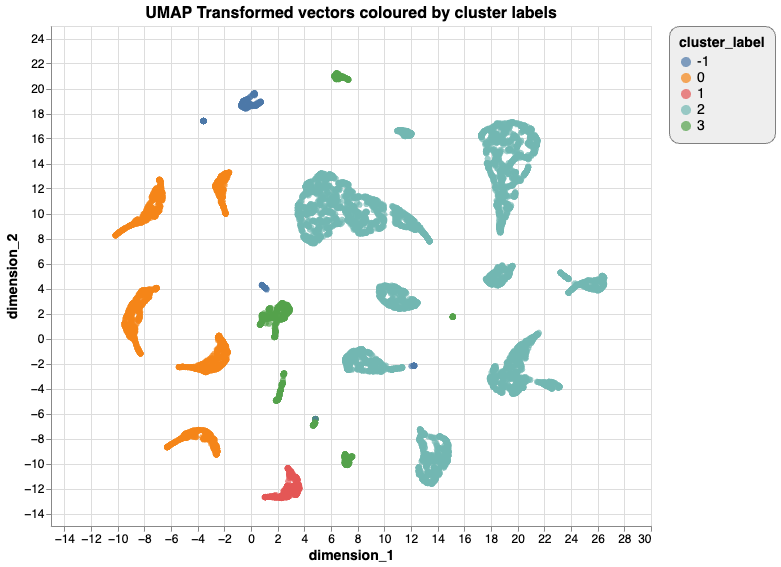

In [21]:
alt.Chart(umap_df).mark_circle(size=40).encode(
    x="dimension_1",
    y="dimension_2",
    color="cluster_label:N"
).properties(
    width=600, 
    height=500,
    title="UMAP Transformed vectors coloured by cluster labels"
).configure_title(
    fontSize=16,
    anchor='middle',
).configure_legend(
    strokeColor='gray',
    fillColor='#EEEEEE',
    padding=10,
    cornerRadius=10,
    labelFontSize=14,
    titleFontSize=14
).configure_axis(
    titleFontSize=14,
    labelFontSize=12
)

We can see our clusters are visually separated. The dark blue ones are outliers (the visible group is not large enough to form it's own cluster). The relative closeness of blobs is due to the limited number of ad_creatives that constitute 1/3 of all vector norm mass.

The green labeled cluster (number 3) is somewhat scattered around - this is a weakness of 2-D representations created by UMAP.

### Understand clusters

In [22]:
# number of users in clusters
user_df["cluster_label"].value_counts()

 2    5099
 0    1692
 3     686
 1     289
-1     234
Name: cluster_label, dtype: int64

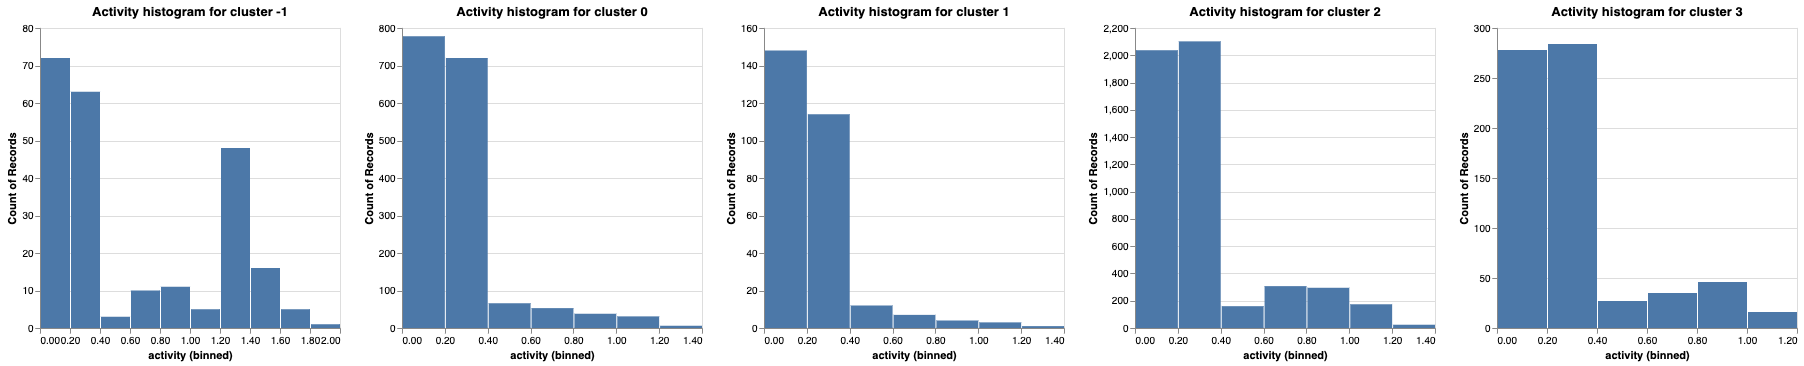

In [23]:
# activity histograms by cluster
# as most user's churn, the outlier group has the highest activity, but on average clusters 2 and 3 are more active than 0 and 1.
by_cluster_data = {label: user_df[user_df["cluster_label"] == label] for label in np.unique(dbscan.labels_)}

activity_histograms = [
        alt.Chart(user_df_part).mark_bar().encode(
            x=alt.X('activity', bin=True),
            y='count()').properties(
            title=f"Activity histogram for cluster {label}"
        ) for label, user_df_part in by_cluster_data.items()
    ]

alt.hconcat(*activity_histograms)

In terms of ad_creatives:
- outliers have all creatives (as expected)
- cluster 1 contains only a certain (non-influencer) creative
- cluster 2 has the influencer based creatives
- and 0 and 3 has all the non-influencer creatives not in cluster 1 (they will be split over signup-date)

In [24]:
pd.DataFrame(user_df.groupby("cluster_label")["ad_creative"].value_counts())

ad_creative
cluster_label ad_creative                                                                                                                                                               
-1            Seeking thrilling gaming adventures? Join our community of gamers and embark on epic quests against worthy adversaries!                                                163
              Unleash your gaming potential! Upgrade to premium for 2 months free and dominate the competition with XYZCr$$d!                                                         13
              Ready to level up? Join XYZCr$$d now for intense gaming battles and exclusive rewards!                                                                                  10
              Embark on your gaming journey with XYZCr$$d! Join now and experience the thrill of competing against the finest players worldwide!                                       9
              Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!                                                  7
              Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!            7
              Become a gaming legend! Join XYZCr$$d now and test your skills against top-tier players from around the globe. Upgrade to premium for 2 months free!                     5
              Calling all gamers! Don't miss out on your chance to excel. Join XYZCr$$d today for unparalleled gaming excitement and endless challenges!                               5
              Join a thriving gaming community and challenge your skills against formidable opponents!                                                                                 5
              Elevate your gaming experience! Upgrade now for 2 months free premium access and immerse yourself in the ultimate gaming community of XYZCr$$d!                          4
              Enter the realm of gaming excellence! Join our vibrant community and compete against some of the most skilled players worldwide!                                         3
              Step into the arena of endless possibilities! Join now to engage in exhilarating gaming competitions and forge friendships with fellow gamers along the way!             3
 0            Step into the arena of endless possibilities! Join now to engage in exhilarating gaming competitions and forge friendships with fellow gamers along the way!           418
              Join a thriving gaming community and challenge your skills against formidable opponents!                                                                               370
              Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!          369
              Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!                                                296
              Enter the realm of gaming excellence! Join our vibrant community and compete against some of the most skilled players worldwide!                                       239
 1            Seeking thrilling gaming adventures? Join our community of gamers and embark on epic quests against worthy adversaries!                                                289
 2            Unleash your gaming potential! Upgrade to premium for 2 months free and dominate the competition with XYZCr$$d!                                                       1772
              Ready to level up? Join XYZCr$$d now for intense gaming battles and exclusive rewards!                                                                                1302
              Embark on your gaming journey with XYZCr$$d! Join now and experience the thrill of compet

In terms of signup date:
- outliers are scattered as usual
- 0 and 1 are from the first campaign
- 2 and 3 are from the new campaign

In [25]:
user_df["singup_datetime"] = [datetime.fromtimestamp(ts) for ts in user_df["signup_date"]]
desc = user_df.groupby("cluster_label")["singup_datetime"].describe(datetime_is_numeric=True)
for col in desc.columns:
    if col == "count":
        continue
    desc[col] = [dt.date() for dt in desc[col]]
desc

count        mean         min         25%         50%  \
cluster_label                                                         
-1              234  2023-12-21  2023-08-23  2023-12-23  2023-12-27   
 0             1692  2023-08-30  2023-08-23  2023-08-25  2023-08-28   
 1              289  2023-08-30  2023-08-23  2023-08-25  2023-08-28   
 2             5099  2023-12-31  2023-12-21  2023-12-24  2023-12-28   
 3              686  2023-12-31  2023-12-21  2023-12-24  2023-12-28   

                      75%         max  
cluster_label                          
-1             2024-01-05  2024-03-11  
 0             2023-09-01  2023-10-19  
 1             2023-09-02  2023-10-03  
 2             2024-01-04  2024-03-09  
 3             2024-01-04  2024-03-01

## Summary
<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;}
.tg td{background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-abip{background-color:#f9f9f9;border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-btxf{background-color:#f9f9f9;border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-fymr">Cluster label</th>
    <th class="tg-fymr">Activity</th>
    <th class="tg-fymr">Ad creatives</th>
    <th class="tg-fymr">Signup date <br>(campaign)</th>
    <th class="tg-fymr"># Users</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-abip">-1 (outliers)</td>
    <td class="tg-btxf">all (mostly high)</td>
    <td class="tg-btxf">all</td>
    <td class="tg-btxf">all</td>
    <td class="tg-btxf">234<br></td>
  </tr>
  <tr>
    <td class="tg-c3ow">0</td>
    <td class="tg-0pky">low number of<br>actives</td>
    <td class="tg-0pky">all non-influencer other than the one for cluster 1</td>
    <td class="tg-0pky">mostly old</td>
    <td class="tg-0pky">1692</td>
  </tr>
  <tr>
    <td class="tg-abip">1</td>
    <td class="tg-btxf">low number of<br>actives</td>
    <td class="tg-btxf">1 specific:<br>"Seeking thrilling gaming adventures? <br>Join our community of gamers and embark on <br>epic quests against worthy adversaries!"</td>
    <td class="tg-btxf">mostly old</td>
    <td class="tg-btxf">289</td>
  </tr>
  <tr>
    <td class="tg-c3ow">2</td>
    <td class="tg-0pky">higher number of <br>actives</td>
    <td class="tg-0pky">influencer based creatives</td>
    <td class="tg-0pky">mostly new</td>
    <td class="tg-0pky">5099</td>
  </tr>
  <tr>
    <td class="tg-abip">3</td>
    <td class="tg-btxf">higher number of <br>actives</td>
    <td class="tg-btxf">all non-influencer other than the one for cluster 1</td>
    <td class="tg-btxf">mostly new</td>
    <td class="tg-btxf">686</td>
  </tr>
</tbody>
</table>